# Создаём точку входа в Spark

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 198 kB 57.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=1d7878dc8bd519e811f8c49247a134552ed69e6e97864f0366595e2cb309db99
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master('local[4]')\
        .appName('Lesson_2')\
        .config('spark.ui.port', '4050')\
        .config('spark.executor.instances', 2)\
        .config('spark.executor.memory', '4g')\
        .config('spark.executor.cores', 2)\
        .getOrCreate()

sc = spark.sparkContext


# Вспомогательная функция

def beautiful_print(rdd, num, title):
    print(title)
    for row in rdd.take(num):
        print('\t', row)

# Самостоятельная работа

Требуется выяснить:
1. Какое соотношение сторон экрана телефона самое популярное,
2. Плотность пикселей у экрана.

Можно использовать только rdd.


## Считывание данных
Данные взяты отсюда: https://www.kaggle.com/iabhishekofficial/mobile-price-classification
Скачиваем и копируем в папку с нотебуком

Внутри содержится следующая информация:

* id: ID
* battery_power: Total energy a battery can store in one time (mAh)
* blue: Support bluetooth or not
* clock_speed: Speed at which microprocessor executes instructions
* dual_sim: Support dual sim or not
* fc: Front Camera mega pixels
* four_g: Support 4G or not
* int_memory: Internal Memory (GB)
* m_dep: Mobile Depth (cm)
* mobile_wt: Weight of mobile phone
* n_cores: Number of cores of processor
* pc: Primary Camera mega pixels
* px_height: Pixel Resolution Height
* px_width: Pixel Resolution Width
* ram: Random Access Memory (MB)
* sc_h: Screen Height of mobile (cm)
* sc_w: Screen Width of mobile (cm)
* talk_time: Time that a single battery charge will last
* three_g: Support 3G or not
* touch_screen: Has touch screen or not
* wifi: Support wifi or not

In [4]:
train = sc.textFile('/content/drive/MyDrive/Colab Notebooks/Spark/train.csv')
beautiful_print(train, 3, 'Train:')
train_first_row = train.first()
print(f"Train size: {train.count()} x {len(train_first_row.split(','))}")

Train:
	 battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
	 842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
	 1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
Train size: 2001 x 21


In [5]:
# Задание 1
#  Прочитайте test.csv
test = sc.textFile('/content/drive/MyDrive/Colab Notebooks/Spark/test.csv')
beautiful_print(test, 3, 'Test:')
test_first_row = test.first()
print(f"Test size: {test.count()} x {len(test_first_row.split(','))}")

Test:
	 id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
	 1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
	 2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
Test size: 1001 x 21


##  Преобразуем train и test

In [6]:
train = train\
    .filter(lambda row: row != train_first_row) \
    .map(lambda row: [float(el) for el in row.split(',')])
    
train_header = train_first_row.split(',')
beautiful_print(train, 3, train_header)

['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range']
	 [842.0, 0.0, 2.2, 0.0, 1.0, 0.0, 7.0, 0.6, 188.0, 2.0, 2.0, 20.0, 756.0, 2549.0, 9.0, 7.0, 19.0, 0.0, 0.0, 1.0, 1.0]
	 [1021.0, 1.0, 0.5, 1.0, 0.0, 1.0, 53.0, 0.7, 136.0, 3.0, 6.0, 905.0, 1988.0, 2631.0, 17.0, 3.0, 7.0, 1.0, 1.0, 0.0, 2.0]
	 [563.0, 1.0, 0.5, 1.0, 2.0, 1.0, 41.0, 0.9, 145.0, 5.0, 6.0, 1263.0, 1716.0, 2603.0, 11.0, 2.0, 9.0, 1.0, 1.0, 0.0, 2.0]


In [7]:
# Задание 2
#  Приведите test.csv к аналогичному виду, что и train

## В train нет колонки 'id' и есть колонка 'price_range' 
## объединене колонок с помощью rdd.union происходит попозиционно, не поименно! Значит нужно обеспечить аналогичный набор и порядок коллонок, чтоб данные верно объединились

test = test\
    .filter(lambda row: row != test_first_row)\
    .map(lambda row: [float(el) for el in row.split(',')])
    
test_header = test_first_row.split(',')
beautiful_print(test, 3, test_header)

['id', 'battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']
	 [1.0, 1043.0, 1.0, 1.8, 1.0, 14.0, 0.0, 5.0, 0.1, 193.0, 3.0, 16.0, 226.0, 1412.0, 3476.0, 12.0, 7.0, 2.0, 0.0, 1.0, 0.0]
	 [2.0, 841.0, 1.0, 0.5, 1.0, 4.0, 1.0, 61.0, 0.8, 191.0, 5.0, 12.0, 746.0, 857.0, 3895.0, 6.0, 0.0, 7.0, 1.0, 0.0, 0.0]
	 [3.0, 1807.0, 1.0, 2.8, 0.0, 1.0, 0.0, 27.0, 0.9, 186.0, 3.0, 4.0, 1270.0, 1366.0, 2396.0, 17.0, 10.0, 10.0, 0.0, 1.0, 1.0]


## Объединим train и test
Найти нужную функцию можно [здесь](https://spark.apache.org/docs/3.1.1/api/python/reference/pyspark.html#rdd-apis)

PS: нужно сделать средсвтвами rdd pd.concat([train, test,], axis=0)

In [8]:
# union для rdd производится попозиуионно, а не поименно.
# нужно, чтоб наборы имели идентичный порядок данных

In [9]:
# из прошлого урока помню, что разница между наборами данных в двух колонках:
# train - 'price_range', test - 'id'
# приводим к одному виду

diff = lambda l1, l2: filter(lambda x: x not in l2, l1) 
print ('Difference: ', list(diff(train_header, test_header)), list(diff(test_header, train_header)))                               

Difference:  ['price_range'] ['id']


In [10]:
train = train.map(lambda row: row[:-1])
test = test.map(lambda row: row[1:])

In [11]:
# Задание 3
#  Объедините данные
data = train.union(test)

data_header = train_header[:-1]

beautiful_print(data, 3, data_header)

['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']
	 [842.0, 0.0, 2.2, 0.0, 1.0, 0.0, 7.0, 0.6, 188.0, 2.0, 2.0, 20.0, 756.0, 2549.0, 9.0, 7.0, 19.0, 0.0, 0.0, 1.0]
	 [1021.0, 1.0, 0.5, 1.0, 0.0, 1.0, 53.0, 0.7, 136.0, 3.0, 6.0, 905.0, 1988.0, 2631.0, 17.0, 3.0, 7.0, 1.0, 1.0, 0.0]
	 [563.0, 1.0, 0.5, 1.0, 2.0, 1.0, 41.0, 0.9, 145.0, 5.0, 6.0, 1263.0, 1716.0, 2603.0, 11.0, 2.0, 9.0, 1.0, 1.0, 0.0]


## Рассчитайте соотношение сторон экрана и его плотность пикселей

In [12]:
# Задание 4
#  Рассчитайте соотношение сторон экрана и найдите широкоформатные, выведите это распределение
# разобрали на уроке

sc_h_col = data_header.index('sc_h')
sc_w_col = data_header.index('sc_w')

data\
  .map(lambda row: (row[sc_h_col], row[sc_w_col]))\
  .filter(lambda row: row[1] != 0)\
  .map(lambda row: (('wide screen' if row[0]/row[1] >= 16/9 else 'not wide screen'), 1))\
  .reduceByKey(lambda x, y: x + y).sortByKey()\
  .collect()

[('not wide screen', 1183), ('wide screen', 1525)]

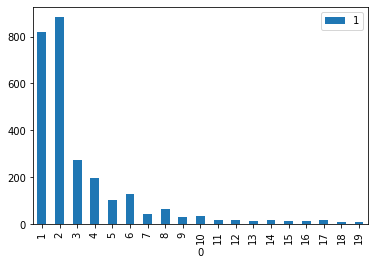

In [15]:
import pandas as pd

sc_h_col = data_header.index('sc_h')
sc_w_col = data_header.index('sc_w')

pd.DataFrame(data\
  .map(lambda row: (row[sc_h_col], row[sc_w_col]))\
  .filter(lambda row: row[1] != 0)\
  .map(lambda row: (round (row[0]/row[1]), 1 ))\
  .reduceByKey(lambda x, y: x + y).sortByKey()\
  .collect())\
  .set_index(0).plot.bar()

In [17]:
# Задание 5
#  Рассчитайте плотность пикселей (лучше ppi), выведите это распределение

height_col = data_header.index('px_height')
width_col = data_header.index('px_width')

data\
  .filter(lambda row: row[sc_h_col] + row[sc_w_col] > 0)\
  .map(lambda row: ((row[height_col]**2 + row[width_col]**2)**(1/2) / (row[sc_h_col]**2 + row[sc_w_col]**2)**(1/2)))\
  .collect()

[66.3287847944442,
 126.53313490223783,
 190.57439492229798,
 120.78457062058878,
 207.51357149097785,
 113.61963162083906,
 71.20920637783695,
 77.27297850831926,
 54.07185513038533,
 77.8081655680639,
 168.70500677319814,
 61.062375636815446,
 53.516842854710724,
 209.3769805876472,
 40.022782320737534,
 90.58328068302457,
 155.75082806196878,
 90.43596331956918,
 47.659325643096516,
 126.28681901028985,
 100.23233710124795,
 99.42768989190776,
 75.91149316487291,
 86.12092753385808,
 114.64735726969731,
 72.70839780321879,
 52.87548695399947,
 63.35175419202534,
 131.76975118263172,
 123.97580409095963,
 108.96726964395563,
 151.6936436982827,
 61.832776612491806,
 275.3196657838792,
 77.58785898624195,
 156.63368752910569,
 62.378910221059265,
 184.61879200302374,
 132.87964479181903,
 100.19716673749922,
 58.5246716788907,
 125.78291609408677,
 65.96366002917397,
 88.56482934715096,
 240.95882543612208,
 212.96009015775707,
 161.20756806055974,
 38.72353935269864,
 115.17571117403

# JOIN
Повторите вышеописанное задание с помощью одной из функций ниже (отдельно рассчитайте для train и test, затем объедините результат)

Пример для двух RDDs: (rdd = {(1, 2), (3, 4), (3, 6)} other = {(3, 9)})

Имя функции |	Purpose |	Example |	Result
------------- |	------- |	------- |	------
subtractByKey |Remove elements with a key present in the other RDD.| rdd.subtractByKey(other) | {(1, 2)}
join | Perform an inner join between two RDDs. | rdd.join(other) | {(3, (4, 9)), (3, (6, 9))}
rightOuterJoin | Perform a join between two RDDs where the key must be present in the first RDD. | rdd.rightOuterJoin(other) | {(3,(Some(4),9)), (3,(Some(6),9))}leftOuterJoin | Perform a join between two RDDs where the key must be present in the other RDD. | rdd.
leftOuterJoin(other) | {(1,(2,None)), (3,(4,Some(9))), (3,(6,Some(9)))}
cogroup | Group data from both RDDs sharing the same key. | rdd.cogroup(other) | {(1,([2],[])), (3,([4, 6],[9]))}


In [ ]:
# Задание 6
#  Рассчитайте для train и test, затем объедините результат

In [19]:
train_sc_h_col = train_header.index('sc_h')
train_sc_w_col = train_header.index('sc_w')

train_result = train\
  .map(lambda row: (row[train_sc_h_col], row[train_sc_w_col]))\
  .filter(lambda row: row[1] != 0)\
  .map(lambda row: (('wide screen' if row[0]/row[1] >= 16/9 else 'not wide screen'), 1))\
  .reduceByKey(lambda x, y: x + y).sortByKey()

In [20]:
test_sc_h_col = test_header.index('sc_h')
test_sc_w_col = test_header.index('sc_w')

test_result = test\
  .map(lambda row: (row[test_sc_h_col], row[test_sc_w_col]))\
  .filter(lambda row: row[1] != 0)\
  .map(lambda row: (('wide screen' if row[0]/row[1] >= 16/9 else 'not wide screen'), 1))\
  .reduceByKey(lambda x, y: x + y).sortByKey()

In [23]:
train_result.take(3)

[('not wide screen', 810), ('wide screen', 1010)]

In [24]:
test_result.take(3)

[('not wide screen', 915), ('wide screen', 85)]

In [21]:
train_result.cogroup(test_result).map(lambda row: (row[0], sum(row[1][0]) + sum (row[1][1]))).collect()

[('not wide screen', 1725), ('wide screen', 1095)]